In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
from jax import jit, grad
import jax.numpy as jnp
from math import prod
import matplotlib.pyplot as plt

import jax
import optax
import functools

# 1 - Layer compilation

In [3]:
reg = jqtc.Register([2,4,3])
cirq = jqtc.Circuit.create(reg, layers=[])

X = jqtc.Gate.create(
    2, 
    name="X",
    gen_U = lambda params: jqtc.sigmax(),
    num_modes=1
)

D = jqtc.Gate.create(
    3, 
    name="D",
    params={"alpha": 1},
    gen_U = lambda params: jqtc.displace(3,params["alpha"]),
    num_modes=1
)

op_X = jqtc.Operation.create(X, 0, reg)
op_D = jqtc.Operation.create(D, 2, reg)

layer = jqtc.Layer.create([op_D, op_X])

layer

Layer(operations=[Operation(gate=D, indices=[2], register=Register(dims=[2, 4, 3])), Operation(gate=X, indices=[0], register=Register(dims=[2, 4, 3]))], _unique_indices=[0, 2], _default_simulate_mode=<SimulateMode.UNITARY: 'unitary'>)

In [4]:
U = layer.gen_U()

In [5]:
(U - (jqt.sigmax() ^ jqt.identity(4) ^ jqt.displace(3,1))).abs().max()

Array(0.+0.j, dtype=complex128)

# 2 - Simulating a Circuit

In [6]:
reg = jqtc.Register([2,4,3])
cirq = jqtc.Circuit.create(reg, layers=[])

X = jqtc.Gate.create(
    2, 
    name="X",
    gen_U = lambda params: jqtc.sigmax(),
    num_modes=1
)

D = jqtc.Gate.create(
    3, 
    name="D",
    gen_U = lambda params: jqtc.displace(3,1),
    num_modes=1
)

op_X = jqtc.Operation.create(X, 0, reg)
op_D = jqtc.Operation.create(D, 2, reg)

layer1 = jqtc.Layer.create([op_X, op_D])

Z = jqtc.Gate.create(
    2, 
    name="Z",
    gen_U = lambda params: jqtc.sigmaz(),
    num_modes=1
)

op_Z = jqtc.Operation.create(Z, 0, reg)

layer2 = jqtc.Layer.create([op_Z])

cirq.append_layer(layer1)
cirq.append_layer(layer2)

In [7]:
initial_state = (jqt.basis(2,0) + jqt.basis(2,1)) ^ jqt.basis(4,0) ^ jqt.basis(3,0)
initial_state = initial_state.unit()
res = jqtc.simulate(cirq, initial_state)

100%|██████████| 2/2 [00:00<00:00, 11.60it/s]


In [8]:
plusstate = (jqt.basis(2,0) -jqt.basis(2,1)).unit()

jqt.ptrace(res.results[2][0], 0) - plusstate.to_dm()

Quantum array: dims = ((2,), (2,)), bdims = (), shape = (2, 2), type = oper
Qarray data =
[[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

# 3 - Simpler circuit writing

## 3.1 - Simulation Options

In [9]:
N = 10
beta = 2
reg = jqtc.Register([2,N])
cirq = jqtc.Circuit.create(reg, layers=[])
cirq.append(jqtc.X(),0)
cirq.append(jqtc.CD(N, beta),[0,1])

100%|██████████| 2/2 [00:00<00:00, 20.18it/s]


Text(35.94444444444453, 0.5, 'Im[α]')

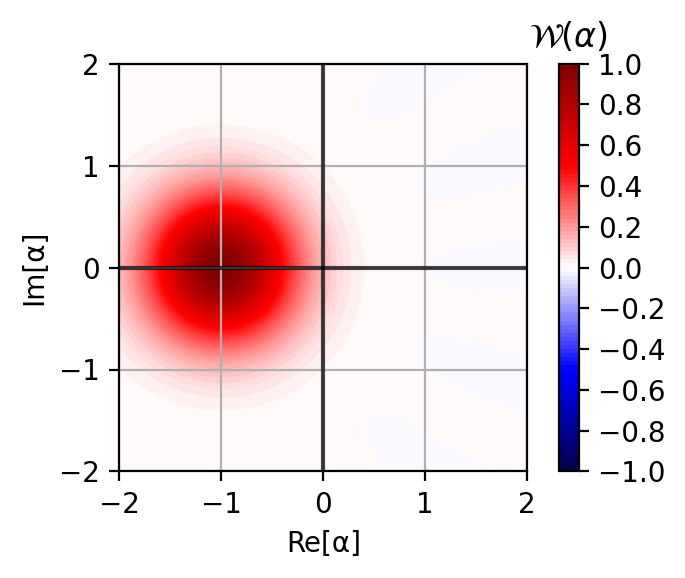

In [10]:
initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
res = jqtc.simulate(cirq, initial_state)

pts = jnp.linspace(-2,2, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(res[-1][-1],1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

100%|██████████| 2/2 [00:00<00:00, 32.19it/s]


Text(35.94444444444453, 0.5, 'Im[α]')

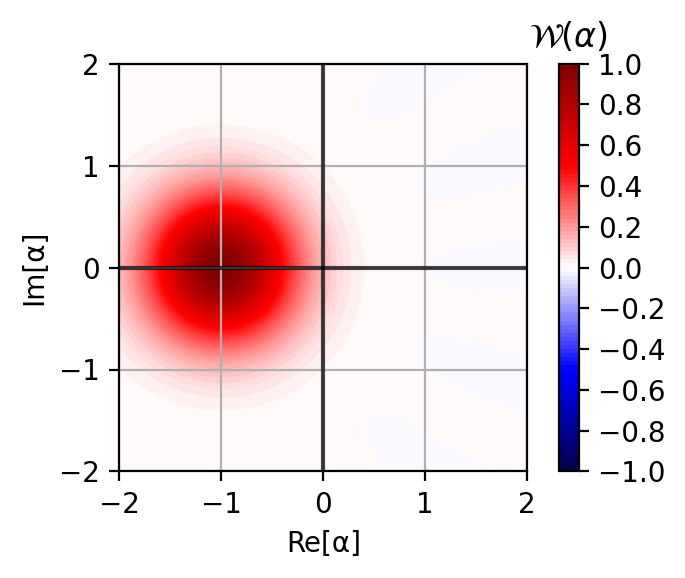

In [11]:
# start with a dm instead

initial_state = jqt.ket2dm(jqt.basis(2,0) ^ jqt.basis(N,0))
res = jqtc.simulate(cirq, initial_state)

pts = jnp.linspace(-2,2, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(res[-1][-1],1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

100%|██████████| 2/2 [00:00<00:00, 18.69it/s]


Text(35.94444444444453, 0.5, 'Im[α]')

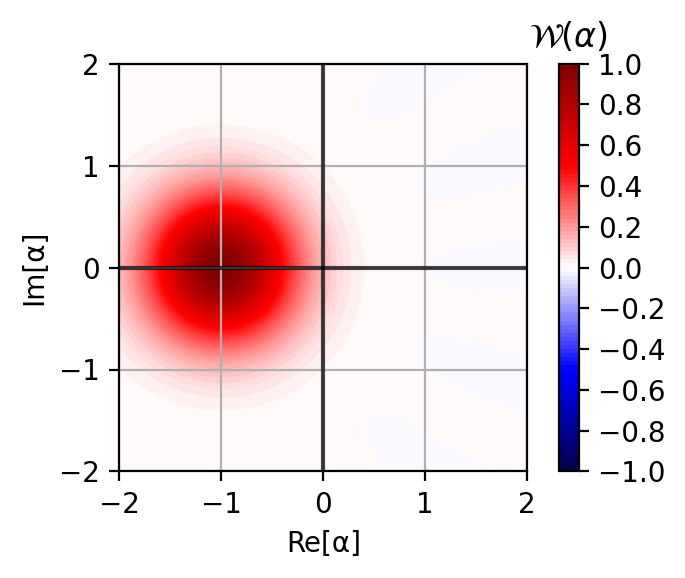

In [12]:
# start with a dm instead

initial_state = jqt.ket2dm(jqt.basis(2,0) ^ jqt.basis(N,0))
res = jqtc.simulate(cirq, initial_state, mode="kraus")

pts = jnp.linspace(-2,2, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(res[-1][-1],1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

## 3.2 - Measurement

In [13]:
reg = jqtc.Register([2])
cirq = jqtc.Circuit.create(reg, layers=[])
cirq.append(jqtc.H(),0)
cirq.append(jqtc.MZ(), 0)

In [14]:
initial_state = jqt.ket2dm(jqt.basis(2,0))
res = jqtc.simulate(cirq, initial_state, mode="kraus")

100%|██████████| 2/2 [00:00<00:00, 14.79it/s]


In [15]:
res

[Quantum array: dims = ((2,), (2,)), bdims = (1,), shape = (1, 2, 2), type = oper
Qarray data =
[[[1.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]], Quantum array: dims = ((2,), (2,)), bdims = (1,), shape = (1, 2, 2), type = oper
Qarray data =
[[[0.5+0.j 0.5+0.j]
  [0.5+0.j 0.5+0.j]]], Quantum array: dims = ((2,), (2,)), bdims = (1,), shape = (1, 2, 2), type = oper
Qarray data =
[[[0.5+0.j 0. +0.j]
  [0. +0.j 0.5+0.j]]]]

# 4 - optimize

### 4a - Cost Function

In [16]:
@jit
def metric(beta):
    beta = beta[0]
    N = 10
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])
    cirq.append(jqtc.X(),0)
    cirq.append(jqtc.CD(N, beta),[0,1])
    
    initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
    res = jqtc.simulate(cirq, initial_state)

    final_state = res[-1][-1]
    target_state = jqt.basis(2,1) ^ (jqt.displace(N, -1.5) @ jqt.basis(N,0))
    return 1 - jnp.real((final_state.dag() @ target_state).data[0][0])
    
metric_grad = grad(metric)

In [17]:
metric(jnp.array([0.5])), metric_grad(jnp.array([0.5]))

100%|██████████| 2/2 [00:00<00:00, 137.32it/s]


(Array(0.54216664, dtype=float64), Array([-0.28614585], dtype=float64))

Following this guide: https://github.com/google-deepmind/optax/blob/main/docs/getting_started.ipynb

### 4b - Adam Optimizer 

In [18]:
start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

# Initialize parameters of the model + optimizer.
params = jnp.array([0.5])
opt_state = optimizer.init(params)

In [19]:
# A simple update loop.
params_history = [params[0]]
for _ in range(1000):
  grads = metric_grad(params)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  params_history.append(params[0])

params_history = jnp.array(params_history)

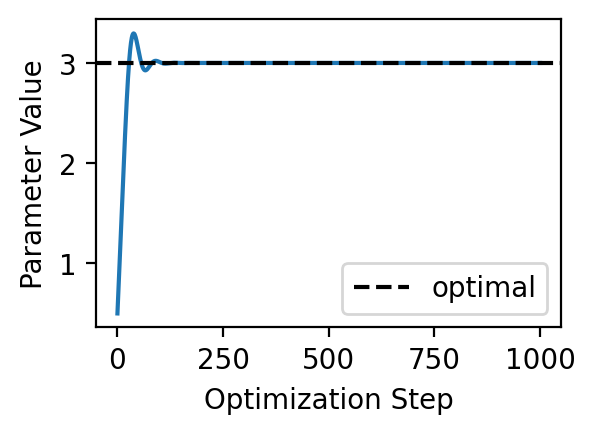

In [20]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(3,2))
ax.plot(params_history)
ax.axhline(3, ls="--", color="black", label="optimal")
ax.set_xlabel("Optimization Step")
ax.set_ylabel("Parameter Value")
ax.legend()

### 4c - custom optimizer

In [21]:

# Exponential decay of the learning rate.
scheduler = optax.exponential_decay(
    init_value=start_learning_rate,
    transition_steps=1000,
    decay_rate=0.99)

# Combining gradient transforms using `optax.chain`.
gradient_transform = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

In [22]:
# Initialize parameters of the model + optimizer.
params = jnp.array([0.5])  # Recall target_params=0.5.
opt_state = gradient_transform.init(params)

# A simple update loop.
params_history = [params[0]]
for _ in range(1000):
  grads = metric_grad(params)
  updates, opt_state = gradient_transform.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  params_history.append(params[0])

params_history = jnp.array(params_history)

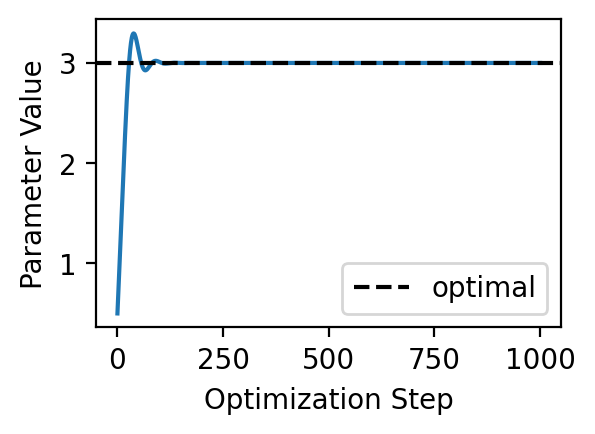

In [23]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(3,2))
ax.plot(params_history)
ax.axhline(3, ls="--", color="black", label="optimal")
ax.set_xlabel("Optimization Step")
ax.set_ylabel("Parameter Value")
ax.legend()

# 5 - Hamiltonian Simulation

### Simple Examples

100% |██████████| [00:00<00:00, 32049.39%/s]
100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Text(35.94444444444453, 0.5, 'Im[α]')

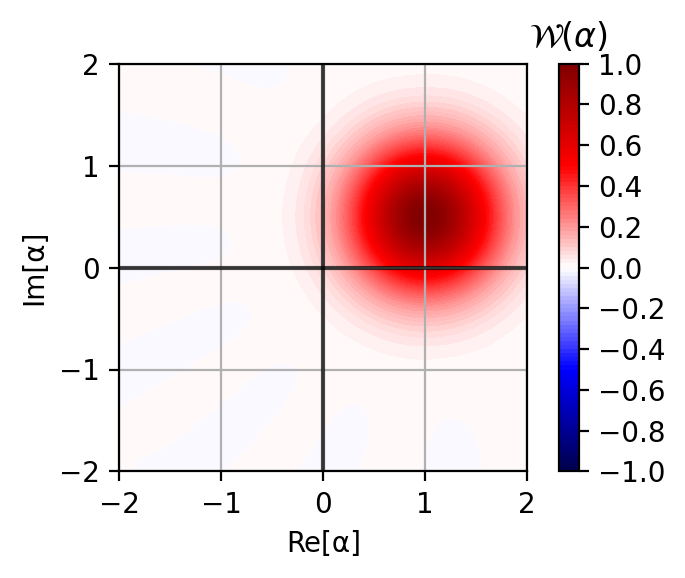

In [24]:
N = 10
beta = 2
reg = jqtc.Register([2,N])
cirq = jqtc.Circuit.create(reg, layers=[])

c_ops = None # jqt.Qarray.from_list([0.2 * jqt.destroy(N)])

cirq.append(jqtc.D(N, 1j, ts=jnp.linspace(0, 100, 101), c_ops = c_ops),1, default_simulate_mode="hamiltonian")
cirq.append(jqtc.D(N, 1), 1)

initial_state = jqt.ket2dm(jqt.basis(2,0) ^ jqt.basis(N,0))
res = jqtc.simulate(cirq, initial_state, mode="default")

pts = jnp.linspace(-2,2, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(res[-1][-1],1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

100% |██████████| [00:00<00:00, 22697.68%/s]
100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


Text(35.94444444444453, 0.5, 'Im[α]')

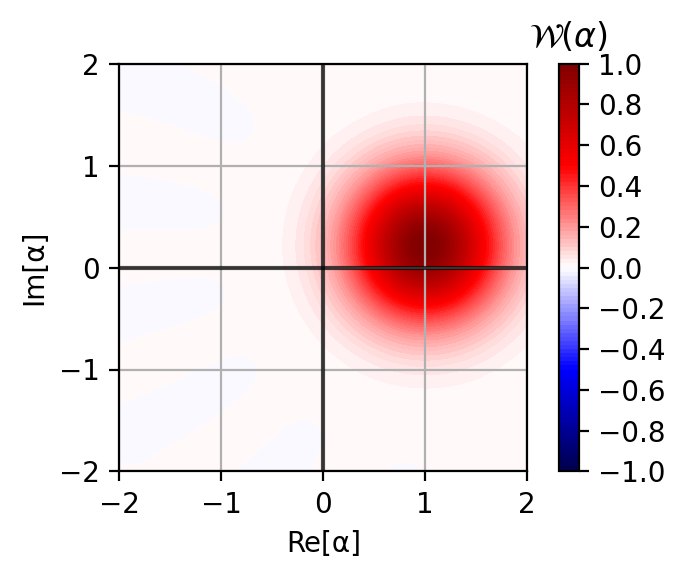

In [25]:
N = 10
beta = 2
reg = jqtc.Register([2,N])
cirq = jqtc.Circuit.create(reg, layers=[])

c_ops = jqt.Qarray.from_list([0.2 * jqt.destroy(N)])

cirq.append(jqtc.D(N, 1j, ts=jnp.linspace(0, 100, 101), c_ops = c_ops),1, default_simulate_mode="hamiltonian")
cirq.append(jqtc.D(N, 1), 1)

initial_state = jqt.ket2dm(jqt.basis(2,0) ^ jqt.basis(N,0))
res = jqtc.simulate(cirq, initial_state, mode="default")

pts = jnp.linspace(-2,2, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(res[-1][-1],1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

100% |██████████| [00:01<00:00, 95.80%/s]
100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


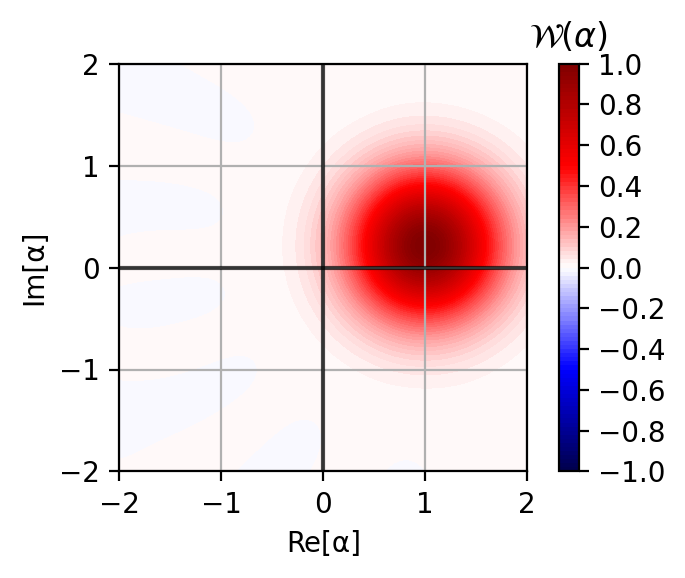

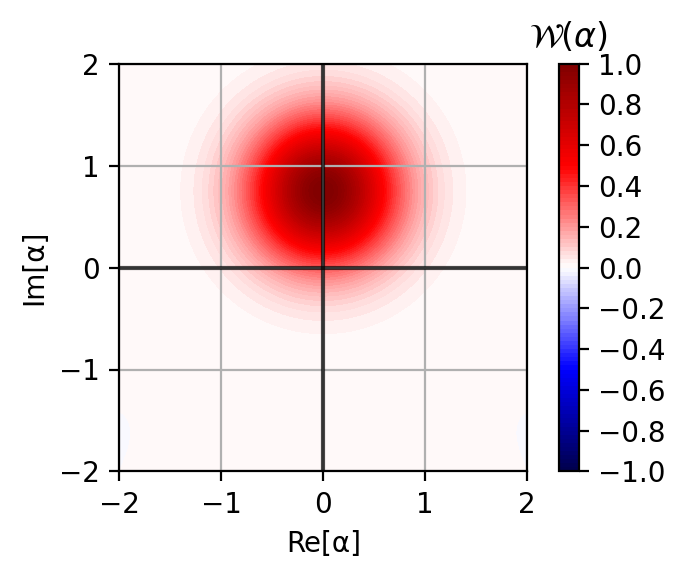

In [26]:
N1 = 10
N2 = 12
beta = 2
reg = jqtc.Register([2,N1,N2])
cirq = jqtc.Circuit.create(reg, layers=[])

c_ops = jqt.Qarray.from_list([0.2 * jqt.destroy(N1)])

d1 = jqtc.D(N1, 1j, ts=jnp.linspace(0, 100, 101), c_ops=c_ops)
d2 = jqtc.D(N2, 1.5j, ts=jnp.linspace(0, 100, 101))


cirq.append(d1, 1, default_simulate_mode="hamiltonian")
cirq.append(d2, 2, new_layer=False)

cirq.append(jqtc.D(N1, 1), 1)

initial_state = jqt.ket2dm(jqt.basis(2,0) ^ jqt.basis(N1,0) ^ jqt.basis(N2,0))
res = jqtc.simulate(cirq, initial_state, mode="default")

pts = jnp.linspace(-2,2, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(res[-1][-1],1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
plt.show()

pts = jnp.linspace(-2,2, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(res[-1][-1],2), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
plt.show()

### Example custom Hamiltonian simulation 

In [29]:
displacement_final = 4.0j # try increasing this to get a larger final displacement!
Na = 100 # and try increasing the resonator size to accommodate larger displacements!
Nq = 2

a = jqt.destroy(Na) ^ jqt.identity(Nq)
sz = jqt.identity(Na) ^ jqt.sigmaz()

# Resonator and qubit frequencies are zero to move into the rotating frame
ωq = 2 * jnp.pi * 0 #0.25 # [2pi x GHz]
ωa = 2 * jnp.pi * 0 #4 # [2pi x GHz]

# Dispersive coupling strength is 32kHz
χ = 2 * jnp.pi * 32e-6 # [2pi x GHz]

t_final = 1000 # [ns]
g_d = displacement_final / t_final / 2
ts = jnp.linspace(0, t_final, 1001)


def Ht(t):
    H = χ * (a.dag() @ a) @ sz + ωq/2 * sz + ωa * (a.dag() @ a)
    # H += jnp.conjugate(1j * g_d) * jnp.exp(1j * ωa * t) * a
    # H += 1j * g_d * jnp.exp(-1j * ωa * t) * a.dag()
    return H

reg = jqtc.Register([Na,Nq])
cirq = jqtc.Circuit.create(reg, layers=[])


D_gate = jqtc.D(Na, displacement_final, ts=ts)
Idle_gate = jqtc.Id([Na,Nq])
Idle_gate = Idle_gate.add_Ht(Ht)

cirq.append(D_gate, 0, default_simulate_mode="hamiltonian")
cirq.append(Idle_gate, [0,1], new_layer=False)

initial_state = jqt.basis(Na, 0) ^ jqt.basis(Nq, 0)
res_g = jqtc.simulate(cirq, initial_state, mode="default")

initial_state = jqt.basis(Na, 0) ^ jqt.basis(Nq, 1)
res_e = jqtc.simulate(cirq, initial_state, mode="default")

100% |██████████| [00:00<00:00, 10593.28%/s]
100%|██████████| 1/1 [00:01<00:00,  1.72s/it]
100% |██████████| [00:00<00:00, 11789.37%/s]
100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


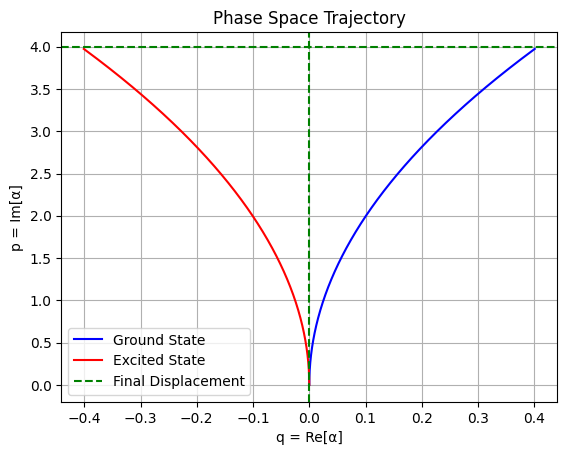

In [30]:
results_g = res_g[1]
results_e = res_e[1]

q = (a + a.dag())
p = 1j * (a.dag() - a)

q_exp_t_g = jqt.overlap(results_g, q)
p_exp_t_g = jqt.overlap(results_g, p)
q_exp_t_e = jqt.overlap(results_e, q)
p_exp_t_e = jqt.overlap(results_e, p)

plt.plot(q_exp_t_g.real, p_exp_t_g.real, color="blue", label="Ground State")
plt.plot(q_exp_t_e.real, p_exp_t_e.real, color="red", label="Excited State")

plt.axhline(jnp.imag(displacement_final), color="green", linestyle="--", label="Final Displacement")
plt.axvline(jnp.real(displacement_final), color="green", linestyle="--")

plt.xlabel("q = Re[α]")
plt.ylabel("p = Im[α]")
plt.title("Phase Space Trajectory")
plt.legend()
plt.grid()
plt.show()

### Echoed Conditional Displacement Gate

In [31]:
alpha = 4.0j # try increasing this to get a larger final displacement!
delay_time = 1000
Na = 100 # and try increasing the resonator size to accommodate larger displacements!
Nq = 2

a = jqt.destroy(Na) ^ jqt.identity(Nq)
sz = jqt.identity(Na) ^ jqt.sigmaz()

# Dispersive coupling strength is 32kHz
χ = 2 * jnp.pi * 32e-6 # [2pi x GHz]
ts = jnp.linspace(0, 100, 1001) # [ns]


def Ht(t):
    H = χ * (a.dag() @ a) @ sz / 2
    return H

idle_gate = jqtc.Id([Na,Nq]) # no times specified
idle_gate = idle_gate.add_Ht(Ht)

delay_gate = jqtc.Id([Na,Nq], ts=jnp.linspace(0, delay_time, 1001))
delay_gate = delay_gate.add_Ht(Ht)

reg = jqtc.Register([Na,Nq])
cirq = jqtc.Circuit.create(reg, layers=[])

# Step 1: Displace out
cirq.append(jqtc.D(Na, alpha, ts=ts), 0, default_simulate_mode="hamiltonian")
cirq.append(idle_gate.copy(), [0,1], new_layer=False)

# Step 2: Wait
cirq.append(delay_gate.copy(), [0,1], default_simulate_mode="hamiltonian")

# Step 3: Displace back
cirq.append(jqtc.D(Na, -alpha*jnp.cos(χ*delay_time/2), ts=ts), 0, default_simulate_mode="hamiltonian")
cirq.append(idle_gate.copy(), [0,1], new_layer=False)

# Step 4: Qubit pi pulse
cirq.append(jqtc.X(), 1)

# Step 5: Displace out again
cirq.append(jqtc.D(Na, -alpha*jnp.cos(χ*delay_time/2), ts=ts), 0, default_simulate_mode="hamiltonian")
cirq.append(idle_gate.copy(), [0,1], new_layer=False)

# Step 6: Wait
cirq.append(delay_gate.copy(), [0,1], default_simulate_mode="hamiltonian")

# Step 7: Displace back
cirq.append(jqtc.D(Na, alpha*jnp.cos(χ*delay_time), ts=ts), 0, default_simulate_mode="hamiltonian")
cirq.append(idle_gate.copy(), [0,1], new_layer=False)

In [32]:
initial_state = jqt.basis(Na, 0) ^ jqt.basis(Nq, 0)
res_g = jqtc.simulate(cirq, initial_state, mode="default")

initial_state = jqt.basis(Na, 0) ^ jqt.basis(Nq, 1)
res_e = jqtc.simulate(cirq, initial_state, mode="default")

100% |██████████| [00:00<00:00, 11834.61%/s]
100% |██████████| [00:00<00:00, 13430.37%/s]
100% |██████████| [00:00<00:00, 11760.61%/s]
100% |██████████| [00:00<00:00, 11095.16%/s]
100% |██████████| [00:00<00:00, 14762.44%/s]
100% |██████████| [00:00<00:00, 11315.77%/s]
100%|██████████| 7/7 [00:07<00:00,  1.08s/it]
100% |██████████| [00:00<00:00, 11837.28%/s]
100% |██████████| [00:00<00:00, 14714.27%/s]
100% |██████████| [00:00<00:00, 11084.02%/s]
100% |██████████| [00:00<00:00, 11547.24%/s]
100% |██████████| [00:00<00:00, 12923.05%/s]
100% |██████████| [00:00<00:00, 10980.72%/s]
100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


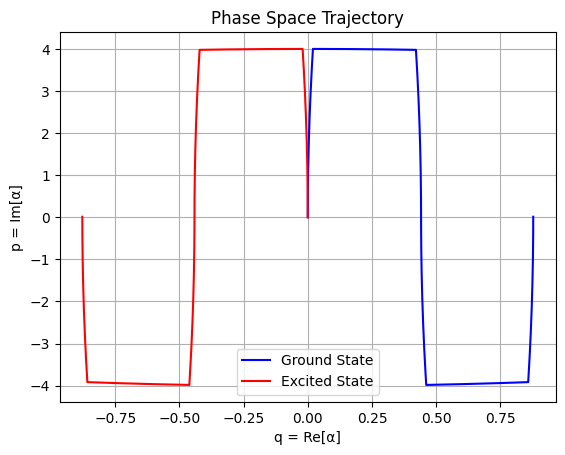

In [33]:
q = (a + a.dag())
p = 1j * (a.dag() - a)

q_exp_t_g = jnp.concatenate([jqt.overlap(res_g_i, q) for res_g_i in res_g])
p_exp_t_g = jnp.concatenate([jqt.overlap(res_g_i, p) for res_g_i in res_g])
q_exp_t_e = jnp.concatenate([jqt.overlap(res_e_i, q) for res_e_i in res_e])
p_exp_t_e = jnp.concatenate([jqt.overlap(res_e_i, p) for res_e_i in res_e])

plt.plot(q_exp_t_g.real, p_exp_t_g.real, color="blue", label="Ground State")
plt.plot(q_exp_t_e.real, p_exp_t_e.real, color="red", label="Excited State")

plt.xlabel("q = Re[α]")
plt.ylabel("p = Im[α]")
plt.title("Phase Space Trajectory")
plt.legend()
plt.grid()
plt.show()